# Dennis Ting - Streaming Service Home Screen
# Movie Recommender System - 01_EDA

**Purpose:** The main purpose of this notebook (01_EDA) is to perform Exploratory Data Analysis (EDA) on the MovieLens dataset, as well as prepare the data for the models in models notebook (02_Models).

Please read this notebook in conjunction with my report, and my other notebooks (see report for full outline).

# Section 0 - Import & Functions

## Import Libraries and Packages

Below, I will import libraries and packages used in the code in this notebook.

In [1]:
# Import - Common Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import time

In [2]:
# Import Libraries for analyzing Tags
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse

## Import Data

In [3]:
# Import Data
df_ratings = pd.read_csv('data/ratings.csv')
df_movies = pd.read_csv('data/movies.csv')
df_tags = pd.read_csv('data/tags.csv')

The above imported data is the MovieLens dataset (more specifically the "MovieLens 25M Dataset") from GroupLens Research, here is a [link to the source](https://grouplens.org/datasets/movielens/).

Below, I will go over a high-level overview of the CSVs imported.

##### CSV overview (with columns):

**ratings.csv** that contains ratings of movies by users:
-	userId
-	movieId
-	rating
-	timestamp

Each line of this file after the header row represents one rating of one movie by one user.

**movies.csv** that contains movie information:
-	movieId
-	title
-	genres

Each line of this file after the header row represents one movie.

**tags.csv** that contains tags applied to movies by users:
-	userId
-	movieId
-	tag
-	timestamp

Each line of this file after the header row represents one tag applied to one movie by one user.

Additional Details on column above:
- User Ids
    - MovieLens users were selected at random for inclusion. Their ids have been anonymized. User ids are consistent between `ratings.csv` and `tags.csv` (i.e., the same id refers to the same user across the two files).

- Movie Ids
    - Only movies with at least one rating or tag are included in the dataset. These movie ids are consistent with those used on the MovieLens web site (e.g., id `1` corresponds to the URL <https://movielens.org/movies/1>). Movie ids are consistent between `ratings.csv`, `tags.csv`, `movies.csv`, and `links.csv` (i.e., the same id refers to the same movie across these four data files). *Note - `link.csv` is not utilized in this project.*
    
- Ratings
    - Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

- Timestamps
    - Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.
- Title
    - The title (i.e. name) of the movie.
- Tag
    - Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user. </br>
</br>

*Note - above descriptions are primarily from the READ ME file provided with the Dataset. I retained a copy of this file in my `data` folder*

## Functions

With EDA, I may create columns to perform checks, filter data, or for a variety of other reasons. I will remove some of these additional columns throughout my EDA process (i.e. after they've served their purpose, etc) and have created a function to help streamline the process. </br>
</br>
The below function is to drop a specific column from a dataset. 
- It will check whether the column exists prior to attempting to drop the column. 
- It will print various messages depending on 

In [4]:
# Drop Column Function

def drop_col_from_df(drop_col_name, drop_df):
    """
    Drops column from dataframe, done in place.
    
    Once column dropped, a check is performed and a message is printed for the user to confirm completion (or otherwise).
    
    :drop_col_name: Name of column to be dropped
    :drop_df: Name of dataframe that contains column to be dropped    
    """

    if drop_col_name in drop_df.columns: # conditional - drop only if column exists
        
        print (f"Does this column exist: {drop_col_name in drop_df.columns}")
        
        drop_df.drop(columns = drop_col_name, axis = 1, inplace = True) 
            # inplace = True, so that the drop method is done inplace in dataframe
        
        # Check after dropping, was it successful? (i.e. column no longer exists)
        if not(drop_col_name in drop_df.columns):     # check column no longer exists
            print ("Success - Dropped column: ", drop_col_name) # Display message when True
            
        else:
            print ("Unsuccessful - Column found but not successfully dropped, perform further inspection")
    
    else: # if column is not in dataframe
        print("Unsuccessful - Column not found in dataframe")

# Section 1 - Collaborative Filtering EDA

## Explore `df_ratings`

I plan to have a model that provides *collaborative based recommendations*. 

*Collaborative* methods for recommender systems are based solely on past interactions between the users and items (in this case, it would be movies) to produce new recommendations.

Thus, I have decided to look at `df_ratings` first, as each row represents one rating of one movie by one user.

### First Look at `df_ratings`

In [5]:
# Visualize the Data
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [6]:
# Get Shape of Data Frame
df_ratings.shape

(25000095, 4)

In [7]:
# Check for missing data
df_ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [8]:
# Check for duplicated rows
df_ratings.duplicated().sum()

0

In [9]:
# Check if a user has reviewed a movie more than once
df_ratings[['userId', 'movieId']].duplicated().sum()

0

In [10]:
# Get Descriptive Statistics
df_ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,25000095.0,8.118928e+04,4.679172e+04,1.0,4.051000e+04,8.091400e+04,1.215570e+05,1.625410e+05
movieId,25000095.0,2.138798e+04,3.919886e+04,1.0,1.196000e+03,2.947000e+03,8.623000e+03,2.091710e+05
rating,25000095.0,3.533854e+00,1.060744e+00,0.5,3.000000e+00,3.500000e+00,4.000000e+00,5.000000e+00
timestamp,25000095.0,1.215601e+09,2.268758e+08,789652009.0,1.011747e+09,1.198868e+09,1.447205e+09,1.574328e+09


In [11]:
# Get number of unique users
df_ratings['userId'].nunique()

162541

In [12]:
# Get number of unique movies
df_ratings['movieId'].nunique()

59047

##### Summary / Findings:
- `df_ratings` has ~25M reviews
- Consistent with the summary in `Import Data` section above, there are  4 columns of data (`userId`, `movieId`, `rating`, `timestamp`)
- There are no null values or duplicate rows in this table. This table is quite clean.
- The `rating` column spans from a minimum of 0.5 to a maximum of 5.0.
- There are ~163K unique users, and ~ 59K unique movies.

## Exploring `df_ratings` in Depth

### Number of Reviews by User

In [13]:
# Look at some statistical metrics on number of ratings by user
df_ratings['userId'].value_counts().describe()

count    162541.000000
mean        153.807932
std         268.047590
min          20.000000
25%          36.000000
50%          71.000000
75%         162.000000
max       32202.000000
Name: userId, dtype: float64

In [14]:
# Look at top 5 users with the highest number of ratings
df_ratings['userId'].value_counts().head()

72315     32202
80974      9178
137293     8913
33844      7919
20055      7488
Name: userId, dtype: int64

In [15]:
# Explore User with Max Reviews - ~32K

32202 * 1.5 / 24 / 365
    # * 1.5 - 1.5 hours high-level approximation of movie length
    # / 24  - transforms hours into days
    # / 365 - transforms figure into years

5.514041095890411

##### Summary / Findings:
- Each user in this dataset has at least 20 reviews.
- The user with the most reviews has ~32K reviews. 
    - Based on a high-level calculation above, it would take about 5.5 years of straight movie watching to finish ~32k movies. Albeit that this figure does not account for sleep, breaks, etc, it is still quite possible that an individual could plausibly have watched / reviewed so this many movies. Thus, I will be leaving the data as is (rather than deleting it or considering other data cleaning alternatives).

In [16]:
# Plot rating by user

# Get number of reviews by users (retrieve values for histogram)
visual_input = df_ratings['userId'].value_counts().values

# Filter out values that are above 162 (Exclude top 25% of users, keep 75% in visualization)
visual_input = visual_input[visual_input <= 162]

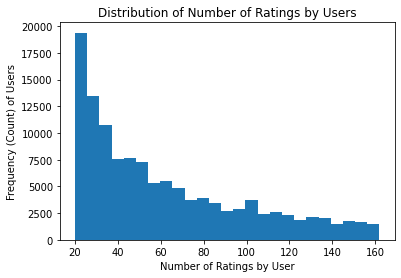

In [17]:
plt.figure()

# Plot histogram
plt.hist(visual_input, bins=25) 

# Titles and Axes
plt.title('Distribution of Number of Ratings by Users')
plt.xlabel('Number of Ratings by User')
plt.ylabel('Frequency (Count) of Users')

plt.show()

##### Summary / Findings:
- For the visualization, I excluded the top 25% of users with the highest number of ratings. 
    - I did this to keep the visualization compact as the top 25% of users were sparse when it came to number of movie ratings (ranging from 163 to ~32K number of ratings).
- Overall, this distribution is right skewed (i.e. tail on the right side), which was consistent with the statistical metrics we saw above. Many users have 20 (or close to 20) ratings, and the number of users per bucket generally tapers offs as we move along the x-axis (Number of Ratings by User).

### Update Ratings Scale

I have decided to convert the ratings range from \[0.5 - 5\] to \[1 - 10\], by multiplying the `rating` column by 2. This will make some of the calculations in the "Net Ratings column" section below easier to code. 

In [18]:
# Change scale from [0.5 - 5] to [1 - 10]
df_ratings['rating'] = df_ratings['rating'] * 2

In [19]:
# Visualize
df_ratings['rating'].head()

0    10.0
1     7.0
2    10.0
3    10.0
4     7.0
Name: rating, dtype: float64

In [20]:
# Change Datatype to int8 to reduce memory consumption (and future processing power needed)
df_ratings['rating'] = df_ratings['rating'].astype(np.int8)

## Data Filtering - `df_ratings`

As mentioned previously, I plan on using this data to perform *collaborative filtering* technique to recommend movies to a user based on ratings from similar users. </br>
</br>
In essence, a user-movie matrix will be produced from the *collaborative filtering* technique:
- each row would contain ratings by each user
- each column would contain ratings received by each movie
</br>

Based on the rounded numbers above, I can expect a matrix with ~9.6 billion cells (with ~163K unique users and ~59K unique movies). The majority of the cells would would be empty as there are ~9.6 billion possible combinations with only ~25 million reviews (i.e. the length of `df_ratings`).
</br>

*Collaborative filtering* is known to be computationally heavy. In my initial phases of my project, I have encountered my fair share of memory issues trying to take on the entire dataset (all ~25 million ratings). I have since reduce the dataset to make it manageable for the computing power I have available to me. Below, I will go through how I reduced the dataset and my relevant thoughts. </br>
</br>

Data Filtering of `df_ratings` overview:
- Keep ratings from recent years
- Filter out movies with less than X ratings (threshold to be explored below)


### Create Datetime column

Below, I will create a new column to show the Unix Timestamp (i.e. `timestamp` column) in the more analysis-friendly DateTime format. 

In [21]:
# Create Date Column, convert timestamp (Unix) to Datetime
df_ratings['date'] = pd.to_datetime(df_ratings['timestamp'], unit='s')
df_ratings

,userId,movieId,rating,timestamp,date
0,1,296,10,1147880044,2006-05-17 15:34:04
1,1,306,7,1147868817,2006-05-17 12:26:57
2,1,307,10,1147868828,2006-05-17 12:27:08
3,1,665,10,1147878820,2006-05-17 15:13:40
4,1,899,7,1147868510,2006-05-17 12:21:50
...,...,...,...,...,...
25000090,162541,50872,9,1240953372,2009-04-28 21:16:12
25000091,162541,55768,5,1240951998,2009-04-28 20:53:18
25000092,162541,56176,4,1240950697,2009-04-28 20:31:37
25000093,162541,58559,8,1240953434,2009-04-28 21:17:14


In [22]:
# Get reviews by year
df_ratings['date'].dt.year.value_counts().sort_index()

1995          3
1996    1430093
1997     626202
1998     272099
1999    1059080
2000    1735398
2001    1058750
2002     776654
2003     920295
2004    1048116
2005    1613550
2006    1038458
2007     931432
2008    1018001
2009     810127
2010     792436
2011     676498
2012     635208
2013     515684
2014     478270
2015    1604971
2016    1757440
2017    1689935
2018    1310761
2019    1200634
Name: date, dtype: int64

In [23]:
# Calculate straight average of rating per year based on total ratings in dataset
mean_review_per_year = df_ratings.shape[0] / ( df_ratings['date'].dt.year.nunique() -1 )
    # Number of ratings / number of years 
    # Note - I decreased number of years calc above by 1 to exclude 1995, which only had 3 reviews in total.

mean_review_per_year # show

1041670.625

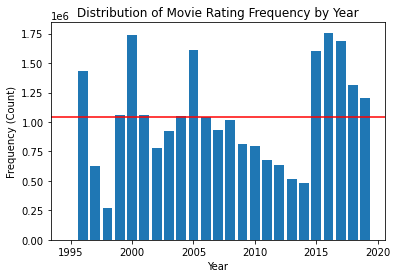

The red line above represents the overall rating per year average


In [24]:
# Plot Frequency of Movie Rating by Year

visual_input = df_ratings['date'].dt.year.value_counts().sort_index()

plt.figure()

# Plot Bar Graph
plt.bar(visual_input.index,
        visual_input.values)

# Titles and Axes
plt.title('Distribution of Movie Rating Frequency by Year')
plt.xlabel('Year')
plt.ylabel('Frequency (Count)')

# Plot horizontal line - average of rating per year 
plt.axhline(y= mean_review_per_year, color = 'red')

plt.show()

print('The red line above represents the overall rating per year average')

##### Summary / Findings:
- Movie Ratings per year is not consistent, it appears to fluctuate year to year with no obvious pattern.
- From 1995 to 2014: 
    - The majority of years have below average movie ratings.
    - 1996, 2000, 2005 have the highest volumes of movie ratings within this timeframe.
- From 2015 - 2019:
    - All years in this range have above average movie ratings. 

### Filter Data by Year

As discussed in the beginning of this section, I will be reducing the dataset. </br>
</br>
Specifically, I will reduce the dataset to only include ratings from the 5 most recent years in the dataset.

In [25]:
# Calculate number of ratings from 2015 - 2019
df_ratings['date'].dt.year.value_counts().filter(items = [2015, 2016, 2017, 2018, 2019]).sum()

7563741

In [26]:
# Create a "year" column
df_ratings['year'] = df_ratings['date'].dt.year

In [27]:
# Filter `df_ratings` for only ratings in Year 2015 or above
df_ratings = df_ratings[df_ratings['year'] >= 2015]

In [28]:
# Check that DataFrame only includes years from 2015 - 2019
np.sort(df_ratings['year'].unique())

array([2015, 2016, 2017, 2018, 2019], dtype=int64)

##### Summary / Findings:
- I have kept ratings data from 2015 to 2019 in our dataset and removed the other datapoints from consideration.

### Filter Data by Movie

As discussed in the beginning of this section, I will be reducing the dataset. </br>
</br>
Specifically, I will reduce the dataset to only include movies with a minimum number of ratings below. The specific threshold will be set below.

In [29]:
# Look at statistics for Movie ID frequency
df_ratings['movieId'].value_counts().describe()

count    58133.000000
mean       130.110970
std        827.338627
min          1.000000
25%          2.000000
50%          5.000000
75%         18.000000
max      28425.000000
Name: movieId, dtype: float64

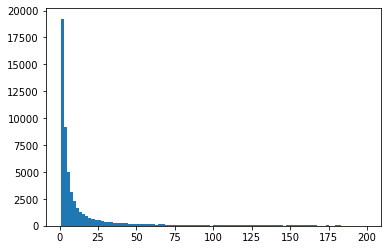

In [30]:
# Plot Movie ID Frequency
plt.figure()

plt.hist(df_ratings['movieId'].value_counts()[df_ratings['movieId'].value_counts() <200].values, bins=100)
plt.show()

##### Comments:
- At least half of the films in `df_ratings` have 5 or less ratings (since the median is 5). 
- The ratings by movie distribution is right skewed (i.e. right tailed). The upper 75% is 18, if I set the cutoff for movies above 18, I can expect to lose over 75% of unique movies in our dataset.

In [31]:
# Get number of rating per user
num_rating_per_movie = df_ratings['movieId'].value_counts()
num_rating_per_movie

2571      28425
79132     27659
318       26208
58559     24443
2959      24086
          ...  
135987        1
160816        1
160850        1
160870        1
200728        1
Name: movieId, Length: 58133, dtype: int64

In [32]:
# Calculate number of unique movies, for various rating minimum cutoffs

cutoff_range = [0, 5, 20, 50, 100, 200, 300, 400, 500, 750, 1000]

for cutoff in cutoff_range:
    
    # Number of unique movies by cutoff
    num_movies_to_keep = len(num_rating_per_movie[num_rating_per_movie >= cutoff])

    # Print Message
    if cutoff == 0:
        print(f"If we keep all movies, there will be {num_movies_to_keep:,} unique movies.")    
    else:
        print(f"If we keep all movies with {cutoff:,} or more ratings, there will be {num_movies_to_keep:,} unique movies.")
    

If we keep all movies, there will be 58,133 unique movies.
If we keep all movies with 5 or more ratings, there will be 29,673 unique movies.
If we keep all movies with 20 or more ratings, there will be 13,906 unique movies.
If we keep all movies with 50 or more ratings, there will be 8,547 unique movies.
If we keep all movies with 100 or more ratings, there will be 6,019 unique movies.
If we keep all movies with 200 or more ratings, there will be 4,195 unique movies.
If we keep all movies with 300 or more ratings, there will be 3,358 unique movies.
If we keep all movies with 400 or more ratings, there will be 2,883 unique movies.
If we keep all movies with 500 or more ratings, there will be 2,488 unique movies.
If we keep all movies with 750 or more ratings, there will be 1,907 unique movies.
If we keep all movies with 1,000 or more ratings, there will be 1,537 unique movies.


In [33]:
# Get users (i.e. index) based on below minimum ratings
min_movie_ratings = 100

movies_keep = num_rating_per_movie[num_rating_per_movie >= min_movie_ratings].index
movies_keep #show 

Int64Index([  2571,  79132,    318,  58559,   2959,   7153,    356,   4993,
            109487,   5952,
            ...
              8642,  25923,   8799, 130510, 180555, 195165,   4292,  48825,
            108787,   1161],
           dtype='int64', length=6019)

In [34]:
# Calculate the number of unique movies to keep in our dataset
len(movies_keep)

6019

In [35]:
# Filter `df_ratings` for ratings from movies in `movies_keep` (above)
df_ratings = df_ratings[df_ratings['movieId'].isin(movies_keep)].copy()

In [36]:
# Check to see if this is the same as above.
df_ratings['movieId'].nunique()

6019

##### Summary / Findings:
- I have kept ratings data from 2015 to 2019 in our dataset and removed the other datapoints from consideration.
- I have decided to only keep movies with 100 or more ratings. By doing so, it greatly reduces the number of unique moviess from our dataset from ~59K to ~6K. This will greatly reduce the size of the user-movie matrix introduced earlier above, and thus reduce the computational power required.
- I have to note that this decision is mainly driven by my hardware constraint. I wanted to keep as many unique movies in the dataset as my machine could handle, since generally-speaking I would expect any model with more data perform better. I tried keeping movies with the 20 / 50 ratings threshold but I consistently experienced memory issues when doing so.  

### Filter out ratings from users with less than 20 reviews

After filtering the data by the year of the rating, and the number of ratings per movie above. I will need to clean up users who now have very little reviews associated to them. </br>
</br>
In the Train Test Split section below, I plan on creating the test dataset by pulling the 10 most recent reviews from each user. I want to have at minimum the same number of ratings (if not more) for the corresponding user in the training dataset. Thus, I have decided to only keep users with 20 or more ratings in the dataset. 

In [37]:
# Get number of rating per user
num_rating_per_user = df_ratings['userId'].value_counts()
num_rating_per_user

72315     5280
57548     4257
33844     3866
107650    3505
123711    3482
          ... 
76168        1
61318        1
113409       1
76269        1
7304         1
Name: userId, Length: 45434, dtype: int64

In [38]:
# Visualize the distribution of ratings by user
num_rating_per_user.describe()

count    45434.000000
mean       154.358212
std        226.049633
min          1.000000
25%         37.000000
50%         76.000000
75%        172.000000
max       5280.000000
Name: userId, dtype: float64

In [39]:
# Get users (i.e. index) with 20 or more reviews
min_user_ratings = 20

users_keep = num_rating_per_user[num_rating_per_user >= min_user_ratings].index
users_keep #show 

Int64Index([ 72315,  57548,  33844, 107650, 123711,  20179, 111038, 115102,
            103611, 156183,
            ...
             23024, 110836,  70057, 154991,  70021,  27936,  97660,  17243,
            102992,  69856],
           dtype='int64', length=43985)

In [40]:
# Calculate unique users
len(users_keep)

43985

In [41]:
# Filter `df_ratings` for ratings from users in `users_keep` (above)
df_ratings = df_ratings[df_ratings['userId'].isin(users_keep)].copy()

In [42]:
# Check to see if this is the same as above unique useres
df_ratings['userId'].nunique()

43985

##### Summary / Findings:
- After the prior filters, I have kept users with 20 or more ratings.

### Review filters performed on `df_ratings` above

In [43]:
# `df_ratings` shape after filters above
df_ratings.shape

(6998416, 6)

In [44]:
# Number of unique movies
df_ratings['movieId'].nunique()

6019

In [45]:
# Number of unique users
df_ratings['userId'].nunique()

43985

In [46]:
# Expected matrix size 
print(f"Expected number of cells in matrix: {df_ratings['movieId'].nunique() * df_ratings['userId'].nunique():,}")

Expected number of cells in matrix: 264,745,715


In [47]:
# Drop `date` and `year` columns
drop_col_from_df('date', df_ratings)
drop_col_from_df('year', df_ratings)

Does this column exist: True
Success - Dropped column:  date
Does this column exist: True
Success - Dropped column:  year


##### Summary / Findings:
- After the filters above, `df_ratings` now has ~ 7 million rows of data, with ~ 44K unique users and ~6K unique movies </br>(from the original ~ 25 million rows of data with ~163K unique users and ~59K unique movies).
- I have dropped the `date` and `year` columns as I no longer need them after filtering the data above.
- By performing the above data filtering, I no longer experience memory issues in the model notebook (02_Models).


# Net Rating column 
**In this section below, I will be creating a new feature.**
</br>
*Create new column - Plus / Minus of User Average* </br>
</br>
The calculation of this column will be: </br>
*(user rating on particular movie) - (average rating for this particular user)* </br>
</br>
In essence, the goal of this column is to capture whether a user liked a movie more (positive figure) or less (negative figure) than their overall average rating, and by how much (i.e. the magnitude of these positive / negative figures). </br>

</br>
The ratings in this dataset are not standardized, and like many rating-type / review-type data in the world these inputs are from humans based on their own experiences. This metric is meant to adjust for each user's rating scale.</br>
</br>
To keep this column similar to the `rating` column, this new feature will have an integer datatype. Thus, when I'm calculating the average rating for each user, I will be rounding each average to the nearest integer. I changed the rating scale from (0.5 - 5.0) to (1 to 10) above to make the rounding in this section easier to perform.</br>

**Note - This column will be named `rating_net_user_mean` and I will refer to this metric as `net rating` in the verbal discussions below.**

### Calculate the average rating for each user

First, I'll need the average rating for each user. I will calculate that below in store it in a separate dataframe.

In [48]:
# Create df_user_mean_rating for average rating by user
df_user_mean_rating = df_ratings.groupby('userId')[['rating']].mean() # calculate average rating, group by userId
df_user_mean_rating.head() # show

,rating
userId,
3,7.388037
4,6.773109
14,9.193548
16,8.958333
17,7.285714


In [49]:
# Rename column
df_user_mean_rating.columns=['user_mean_rating']

# Round `user_mean_rating` column
df_user_mean_rating['user_mean_rating'] = df_user_mean_rating['user_mean_rating'].round(0) # number of decimal places

In [50]:
# Change Datatype to int8 to reduce memory consumption (and future processing power needed)
df_user_mean_rating['user_mean_rating'] = df_user_mean_rating['user_mean_rating'].astype(np.int8)

In [51]:
# move userId from index to column
df_user_mean_rating.reset_index(inplace=True) # inplace = True, so it's done directly in data frame
df_user_mean_rating.head() # show

,userId,user_mean_rating
0,3,7
1,4,7
2,14,9
3,16,9
4,17,7


In [52]:
# Check for missing data
df_user_mean_rating.isna().sum()

userId              0
user_mean_rating    0
dtype: int64

In [53]:
df_user_mean_rating.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,43985.0,81256.997090,46991.331596,3.0,40338.0,81183.0,122261.0,162538.0
user_mean_rating,43985.0,7.651245,1.107656,1.0,7.0,8.0,8.0,10.0


### Calculate Net Rating (`rating_net_user_mean`)

Below, I will first merge `df_ratings` with the average rating by user calculated above. Then,  I will perform the net rating calculation in `df_rating` and store it in columng `rating_net_user_mean`.

In [54]:
# Merge Average User Rating with `df_ratings`
df_ratings = pd.merge(left=df_ratings,           # left table
                      right=df_user_mean_rating, # right table
                      how='left',                # left join (i.e. return all records on left table)
                      left_on='userId',          # column to join on left table
                      right_on='userId')         # column to join on right table

In [55]:
# Visualize
df_ratings.head()

,userId,movieId,rating,timestamp,user_mean_rating
0,3,1,8,1439472215,7
1,3,29,9,1484754967,7
2,3,32,9,1439474635,7
3,3,50,10,1439474391,7
4,3,111,8,1484753849,7


In [56]:
# Create column for rating net user's mean
    # individual movie rating less user's mean rating
df_ratings['rating_net_user_mean'] = df_ratings['rating'] - df_ratings['user_mean_rating']

# Change Datatype to int8 to reduce memory consumption (and future processing power needed)
df_ratings['rating_net_user_mean'] = df_ratings['rating_net_user_mean'].astype(np.int8)

df_ratings.head() #show

,userId,movieId,rating,timestamp,user_mean_rating,rating_net_user_mean
0,3,1,8,1439472215,7,1
1,3,29,9,1484754967,7,2
2,3,32,9,1439474635,7,2
3,3,50,10,1439474391,7,3
4,3,111,8,1484753849,7,1


In [57]:
df_ratings[['rating', 'user_mean_rating', 'rating_net_user_mean']].describe().T

,count,mean,std,min,25%,50%,75%,max
rating,6998416.0,7.164706,2.142003,1.0,6.0,8.0,9.0,10.0
user_mean_rating,6998416.0,7.165552,1.150219,1.0,7.0,7.0,8.0,10.0
rating_net_user_mean,6998416.0,-0.000846,1.854632,-9.0,-1.0,0.0,1.0,8.0


In [58]:
# Drop the `user_mean_rating` column
drop_col_from_df('user_mean_rating',df_ratings)

Does this column exist: True
Success - Dropped column:  user_mean_rating


##### Summary / Findings:
- The `rating` column spans from a minimum of 1 to a maximum of 10.
- The `user_mean_rating` column is the average rating by user rounded to the nearest integer. This column also spans from a minimum of 1 to a maximum of 10, which indicates that there are users that have exclusively rated films with a score of 1 and other users that have exclusively rated films with a score of 10. 
    - This column has been dropped after calculating the `rating_net_user_mean` column.

- The `rating_net_user_mean` column (Net Rating column) spans from a minimum of -9 to a maximum of 8. The theoretical minimum and maximum would be -9, and 9, respectively. 

**I will perform the Train Test split below prior to visualizing the `rating` and ` rating_ner_user_mean` (Net Rating) columns.**

## Train Test Split

In the real-world scenario, recommender systems are used to recommend new items (i.e. movies) to users based on their historical data. Instead of performing a train test split at random, I will instead split the data based on the date of the rating (`timestamp` column). 

The test set will comprise of the 10 of the most recently reviewed movie by each user. The remainder of the data will be placed in the train set. I will not be explicitly defining a validation set as I will be using cross validation in Grid Search (see 02_Models notebook).

In [59]:
# Rank the `timestamp` column in descending order by user
    # method = 'first', will return value of 1 for the largest timestamp (filtering above)
df_ratings['rank_first'] = df_ratings.groupby(['userId'])['timestamp'].rank(method='first', ascending=False)

In [60]:
# Check maximum value to determine datatype that can be used to reduce memory
df_ratings['rank_first'].max()

5280.0

In [61]:
# Change Datatype to int16 to reduce memory consumption (and future processing power needed)
df_ratings['rank_first'] = df_ratings['rank_first'].astype(np.int16)

In [62]:
# Visualize Data
df_ratings.head()

,userId,movieId,rating,timestamp,rating_net_user_mean,rank_first
0,3,1,8,1439472215,1,649
1,3,29,9,1484754967,2,204
2,3,32,9,1439474635,2,327
3,3,50,10,1439474391,3,347
4,3,111,8,1484753849,1,218


In [63]:
# Create a column called `test_data` - default value 0
df_ratings['test_data'] = 0

# Change Datatype to int8 to reduce memory consumption (and future processing power needed)
df_ratings['test_data'] = df_ratings['test_data'].astype(np.int8)

# For rows where `rank_first` is equal to 1, set `test_data` value to 1
df_ratings.loc[df_ratings['rank_first'] <= 10, 'test_data'] = 1

In [64]:
df_ratings.head()

,userId,movieId,rating,timestamp,rating_net_user_mean,rank_first,test_data
0,3,1,8,1439472215,1,649,0
1,3,29,9,1484754967,2,204,0
2,3,32,9,1439474635,2,327,0
3,3,50,10,1439474391,3,347,0
4,3,111,8,1484753849,1,218,0


In [65]:
# Drop `rank_first` column
drop_col_from_df('rank_first', df_ratings)

Does this column exist: True
Success - Dropped column:  rank_first


In [66]:
# Set up Train / Test Dataframes by creating a copy of ratings dataframe
df_train_ratings = df_ratings.copy()
df_test_ratings = df_ratings.copy()

# Split Train / Test data
df_train_ratings = df_train_ratings.loc[df_ratings['test_data']!=1] # train where `test_data` not equal to 1
df_test_ratings = df_test_ratings.loc[df_ratings['test_data']==1]   # test where `test_data` equal to 1


In [67]:
# Visualize the train data
df_train_ratings.head()

,userId,movieId,rating,timestamp,rating_net_user_mean,test_data
0,3,1,8,1439472215,1,0
1,3,29,9,1484754967,2,0
2,3,32,9,1439474635,2,0
3,3,50,10,1439474391,3,0
4,3,111,8,1484753849,1,0


In [68]:
# Get Shape of the train data
df_train_ratings.shape

(6558566, 6)

In [69]:
# Quick Sanity check of train data
df_train_ratings['test_data'].value_counts()

0    6558566
Name: test_data, dtype: int64

In [70]:
# Visualize the test data
df_test_ratings.head()

,userId,movieId,rating,timestamp,rating_net_user_mean,test_data
52,3,1732,9,1566091883,2,1
124,3,4262,9,1566091872,2,1
467,3,79091,8,1566091612,1,1
478,3,81834,7,1566091630,0,1
501,3,87876,7,1566091557,0,1


In [71]:
# Get Shape of the test data
df_test_ratings.shape

(439850, 6)

In [72]:
# Quick Sanity check of test data
df_test_ratings['test_data'].value_counts()

1    439850
Name: test_data, dtype: int64

In [73]:
# Drop test_data column
drop_col_from_df('test_data', df_train_ratings)
drop_col_from_df('test_data', df_test_ratings)

Does this column exist: True
Success - Dropped column:  test_data
Does this column exist: True
Success - Dropped column:  test_data


In [74]:
# Check 
    # Per user, the smallest timestamp in the test data should still be larger than the max timestamp in the train data
    # (i.e. the earliest time in the test data is still later than the latest timestamp in the train data)
(df_test_ratings.groupby('userId')['timestamp'].min() < df_train_ratings.groupby('userId')['timestamp'].max()).sum()
    # should be zero, if the above is true

0

In [75]:
# Check
    # Expect that the test database will have rows equal to 10 * number of unique users in the `df_ratings` 
(df_test_ratings.shape[0]) == (df_ratings['userId'].nunique() * 10 )
    # Should return true

True

##### Summary / Findings:
- I have successfully split my data into train and test datasets.
- The test data comprises 10 of the most recently reviewed movie by each user. There are ~ 440K rows.
- The train data comprises the remaining data, there are ~6.6 million rows.
- There is quite a difference in size between train and test data, which is intentional. To reiterate what I mentioned above, I want to have at minimum the same number of ratings (if not more) for the corresponding user in the training dataset. With the minimum of movies rated by user of 20, this led to putting only 10 aside for each user into the test data.
- I will need to revisit the `rating_net_user_mean` column for the train dataset, more details below.

### Clean up Train Data

The test dataset should not be used at all during the model fitting / tuning phases, and should not be used to influence the model in anyway. Currently, the average rating for each user (rounded to the nearest integer) comprises of data points that are now in our test dataset. Prior to the clean up performed below, the test set is influencing the `rating_net_user_mean` feature in our train dataset. </br>
</br>
**I will recalculate the `rating_net_user_mean` column for the train dataset using only data available in our train set.**

In [76]:
# Drop `rating_net_user_mean` in `df_train_ratings`
drop_col_from_df('rating_net_user_mean', df_train_ratings)

# Note - this column will be reinstated with calculation in cells below

Does this column exist: True
Success - Dropped column:  rating_net_user_mean


In [77]:
# Clear `df_user_mean_rating` for training set calculation
df_user_mean_rating = pd.DataFrame() # empty DataFrame

In [78]:
# Create df_user_mean_rating for average rating by user
df_user_mean_rating = df_train_ratings.groupby('userId')[['rating']].mean() # calculate average rating, group by userId

# Rename column
df_user_mean_rating.columns=['user_mean_rating']

# Round `user_mean_rating` column
df_user_mean_rating['user_mean_rating'] = df_user_mean_rating['user_mean_rating'].round(0) # number of decimal places

# Change Datatype to int8 to reduce memory consumption (and future processing power needed)
df_user_mean_rating['user_mean_rating'] = df_user_mean_rating['user_mean_rating'].astype(np.int8)

# move userId from index to column
df_user_mean_rating.reset_index(inplace=True) # inplace = True, so it's done directly in data frame

In [79]:
# Check for missing data
df_user_mean_rating.isna().sum()

userId              0
user_mean_rating    0
dtype: int64

In [80]:
#### Merge Average User Rating with `df_train_ratings`

# Merge Average User Rating with `df_train_ratings`
df_train_ratings = pd.merge(left=df_train_ratings,     # left table
                            right=df_user_mean_rating, # right table
                            how='left',                # left join (i.e. return all records on left table)
                            left_on='userId',          # column to join on left table
                            right_on='userId')         # column to join on right table

# Create column for rating net user's mean
    # individual movie rating less user's mean rating
df_train_ratings['rating_net_user_mean'] = df_train_ratings['rating'] - df_train_ratings['user_mean_rating']

# Change Datatype to int8 to reduce memory consumption (and future processing power needed)
df_train_ratings['rating_net_user_mean'] = df_train_ratings['rating_net_user_mean'].astype(np.int8)

In [81]:
# Visualize
df_train_ratings.head() #show

,userId,movieId,rating,timestamp,user_mean_rating,rating_net_user_mean
0,3,1,8,1439472215,7,1
1,3,29,9,1484754967,7,2
2,3,32,9,1439474635,7,2
3,3,50,10,1439474391,7,3
4,3,111,8,1484753849,7,1


In [82]:
# Drop the `user_mean_rating` column
drop_col_from_df('user_mean_rating',df_train_ratings)

Does this column exist: True
Success - Dropped column:  user_mean_rating


##### Summary / Findings:
- I have successfully recalculated the `rating_net_user_mean` column in the train dataset using data from the train dataset only. This prevents any data from the test dataset to leaking into the train dataset / model training.

### Ratings Visualization

*`rating` column*

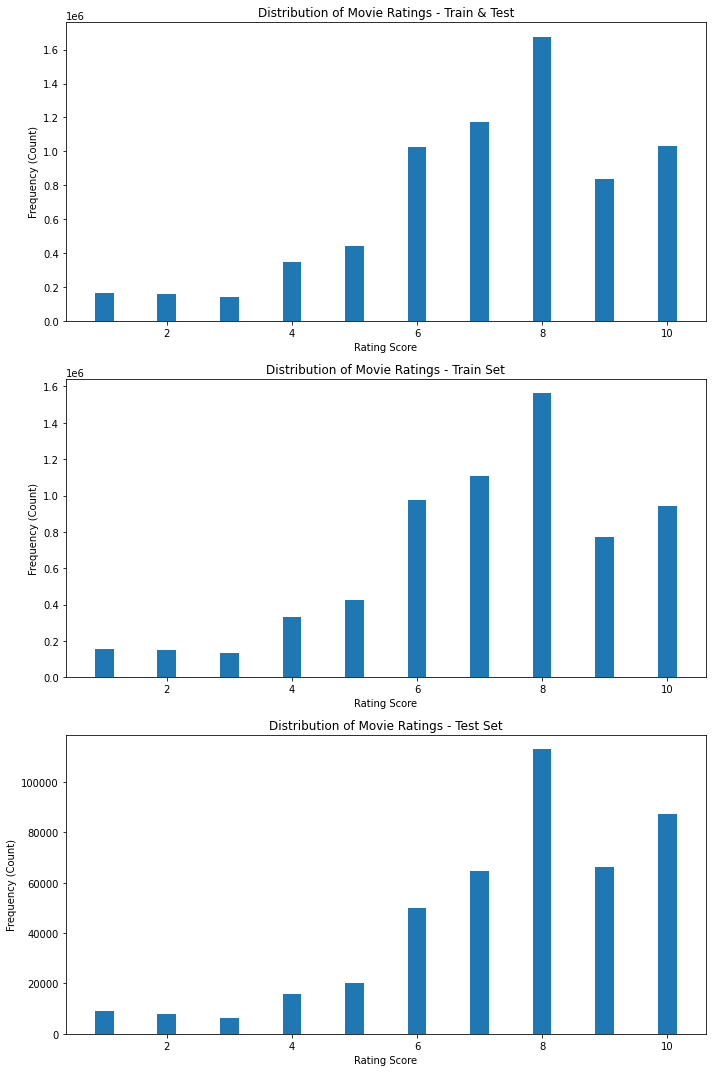

In [83]:
# Visualize Movie Ratings (1 - 10)

row_max = 3
col_max = 1
list_of_df = [df_train_ratings, df_test_ratings]

plt.subplots(row_max, col_max, figsize=(10,15))

# Plot 1 - Overall
plt.subplot(row_max, col_max, 1)
visual_input = df_ratings['rating'].value_counts().sort_index()

# Plot Bar Graph
plt.bar(visual_input.index,
        visual_input.values, 
        width = 0.3, align='center') # Adjust bar width and alignment 

# Titles and Axes
plt.title('Distribution of Movie Ratings - Train & Test')
plt.xlabel('Rating Score')
plt.ylabel('Frequency (Count)')


# Plot 2 - Train
plt.subplot(row_max, col_max, 2)

# Train
visual_input = df_train_ratings['rating'].value_counts().sort_index()


# Plot Bar Graph
plt.bar(visual_input.index,
        visual_input.values, 
        width = 0.3, align='center') # Adjust bar width and alignment 

# Titles and Axes
plt.title('Distribution of Movie Ratings - Train Set')
plt.xlabel('Rating Score')
plt.ylabel('Frequency (Count)')


# Plot 3 - Test
plt.subplot(row_max, col_max, 3)

visual_input = df_test_ratings['rating'].value_counts().sort_index()

# Plot Bar Graph
plt.bar(visual_input.index,
        visual_input.values, 
        width = 0.3, align='center') # Adjust bar width and alignment 

# Titles and Axes
plt.title('Distribution of Movie Ratings - Test Set')
plt.xlabel('Rating Score')
plt.ylabel('Frequency (Count)')

plt.tight_layout()
plt.show()

In [84]:
# Mean and Median - Overall
df_ratings['rating'].describe()[['mean', '50%']]

mean    7.164706
50%     8.000000
Name: rating, dtype: float64

In [85]:
# Mean and Median - Train 
df_train_ratings['rating'].describe()[['mean', '50%']]

mean    7.137433
50%     7.000000
Name: rating, dtype: float64

In [86]:
# Mean and Median - Test
df_test_ratings['rating'].describe()[['mean', '50%']]

mean    7.571379
50%     8.000000
Name: rating, dtype: float64

##### Comments:
- The distribution in both the train and test dataset are similar to each other, and the overall (both train & test) dataset.
    - There is a single peak, the rating of 8 is the most frequent for both the train and test datasets (i.e. the mode).
    - Generally speaking, the frequency of ratings decreases as you move further out from the peak (rating of 8) both on the left (lower ratings) and the right side (higher ratings). The notable exception is that there are more ratings of 10 versus ratings of 9.
    - They are all left-skewed (i.e. left tail), the majority of data are located on the high ratings side (right side of the graphs).

- The average rating for the train dataset is ~7, whereas the average rating for the test dataset is ~7.5. This is mainly driven by the higher proportions of 9 and 10 ratings in the test dataset compared to the train dataset.

*`rating_net_user_mean` column*

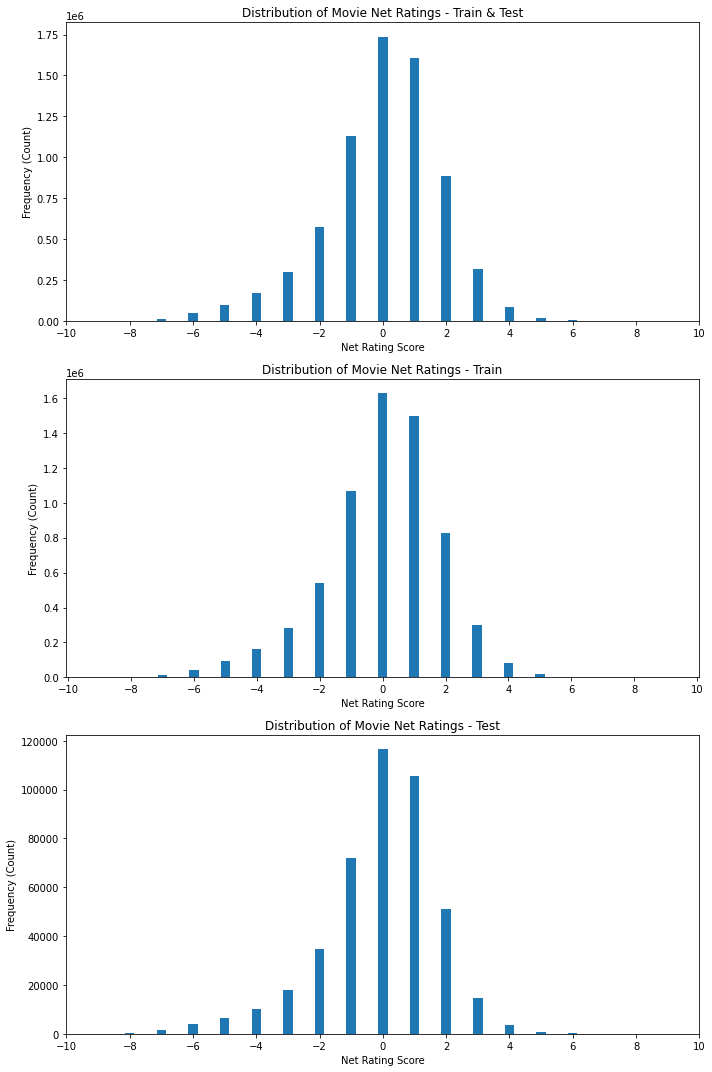

In [87]:
# Visualize Movie Net Ratings (-9 - 9, potential range)

row_max = 3
col_max = 1
list_of_df = [df_train_ratings, df_test_ratings]

plt.subplots(row_max, col_max, figsize=(10,15))

# Plot 1 - Overall
plt.subplot(row_max, col_max, 1)

visual_input = df_ratings['rating_net_user_mean'].value_counts()

# Plot Bar Graph
plt.bar(visual_input.index,
        visual_input.values, 
        width = 0.3, align='center') # Adjust bar width and alignment 

# Titles and Axes
plt.title('Distribution of Movie Net Ratings - Train & Test')
plt.xlabel('Net Rating Score')
plt.ylabel('Frequency (Count)')
plt.xticks(range(-10,11,2))


# Plot 2 - Train
plt.subplot(row_max, col_max, 2)

# Train
visual_input = df_train_ratings['rating_net_user_mean'].value_counts()

# Plot Bar Graph
plt.bar(visual_input.index,
        visual_input.values, 
        width = 0.3, align='center') # Adjust bar width and alignment 

# Titles and Axes
plt.title('Distribution of Movie Net Ratings - Train')
plt.xlabel('Net Rating Score')
plt.ylabel('Frequency (Count)')
plt.xticks(range(-10,11,2))


# Plot 3 - Test
plt.subplot(row_max, col_max, 3)

# Test
visual_input = df_test_ratings['rating_net_user_mean'].value_counts()

# Plot Bar Graph
plt.bar(visual_input.index,
        visual_input.values, 
        width = 0.3, align='center') # Adjust bar width and alignment 

# Titles and Axes
plt.title('Distribution of Movie Net Ratings - Test')
plt.xlabel('Net Rating Score')
plt.ylabel('Frequency (Count)')
plt.xticks(range(-10,11,2))

plt.tight_layout()
plt.show()

In [88]:
# Statistics - Overall
df_ratings['rating_net_user_mean'].describe()

count    6.998416e+06
mean    -8.457628e-04
std      1.854632e+00
min     -9.000000e+00
25%     -1.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      8.000000e+00
Name: rating_net_user_mean, dtype: float64

In [89]:
# Statistics - Train 
df_train_ratings['rating_net_user_mean'].describe()

count    6.558566e+06
mean    -6.518193e-04
std      1.853815e+00
min     -9.000000e+00
25%     -1.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      9.000000e+00
Name: rating_net_user_mean, dtype: float64

In [90]:
# Statistics - Test
df_test_ratings['rating_net_user_mean'].describe()

count    439850.000000
mean         -0.079866
std           1.833022
min          -9.000000
25%          -1.000000
50%           0.000000
75%           1.000000
max           8.000000
Name: rating_net_user_mean, dtype: float64

##### Comments:
- The distribution in both the train and test dataset are similar to each other, and the overall (both train & test) dataset.
    - There is a single peak, the rating of 0 is the most frequent for both the train and test datasets (i.e. the mode). They are all a bell-liked shape. The mean and median for both train and test datasets is a rating of 0 (note - for the mean it's not exactly zero but essentially zero). 
    - Generally speaking, the frequency of ratings decreases as you move further out from the peak (rating of 0) both on the left (lower ratings) and the right side (higher ratings). 
    - The standard deviation of ~1.8 for both train and test dataset, indicate how far the average net rating lies from the mean. We can see that the majority of our data lies between -2 and 2 (rounded up from 1.8) in the visuals above.  
    - We can see that the data on the right side is more compressed than the left side. This is consistent to what we saw when we visualized the `rating` column above. The mean is ~ 7 so we can expect that many user's mean will be ~7 and close to it where it's expected that there will be higher concentration in lower positive net rating numbers than there are in lower negative net rating numbers. 
        - For example if a user mean was 7, the possible positive net ratings would be 1, 2, and 3 (i.e. up to a rating of 10), whereas the possible negative net ratings would be -1, -2, -3, -4, -5, -6. 


**Note - the above concludes the EDA on ratings data for the *collaborative based recommendations*. I will export the train and test datasets for the 02_Models notebook at the end of this file.**

# Section 2 - Top Movies

A major issue that *collaborative filtering* faces is the **cold start** issue. In essence, how do we deal with users where we have limited to no data about them. 

I can provide users a list of "top" or "popular" movies regardless of their history, which could help with this issue. This would be considered a **user independent system**. Additionally, these new user viewing patterns / ratings based on these "top" or "popular" movies will help us build data for future recommendations.

## Look at "Top" Movies

In this section, I'll try to answer the question:</br>
&emsp;*What are the top movies in this dataset?* </br>
</br>
This may seem like a simple question at a quick glance but as I gave more thought, the harder it was to answer this question. In essence, the main question is how to we define a top movie, and how can we measure that. </br>
</br>
Below I will look rank movies based on: 
- Count of ratings
- Average rating
- Total net rating
- Average net rating </br>
</br>

Based on this (non-exhaustive) list, I will choose a metric to determine the "Top" movies. 

### Create `df_summary_movies` 

I will create a new DataFrame to house the various movie metrics.

In [91]:
# Create new DataFrame
df_summary_movies = pd.DataFrame()

### Add Metrics to `df_summary_movies`

**Movie IDs**

I am getting the list of movie IDs from the `df_ratings` dataframe. I will note that this is the `df_ratings` dataframe with ~7 million rows, instead of the original `df_ratings` which came with ~25 million rows. As mentioned above, I reduced the size of this dataset due to computation limitations (memory errors from applying collaborative filtering techniques to the original 25 million rows). </br>
</br>
I am using the updated `df_ratings` to be consistent with the data prepared for the collaborative filtering techniques. Furthermore, by using movies directly in `df_ratings`, which means that there will be rating and net rating data available for these movies (instead of pulling the full list of movies from `df_movies`).

In [92]:
# Add all unique Movie IDs from `df_ratings` (in ascending order)
df_summary_movies['movieId'] = np.sort(df_ratings['movieId'].unique())

*First Look at `df_movies`*

In [93]:
# Visualize 
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [94]:
# Get Shape of Data Frame
df_movies.shape

(62423, 3)

In [95]:
# Check for missing data - after dropping rows
df_movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [96]:
# Check for duplicated rows
df_movies.duplicated().sum()

0

**Movie Titles**

I will grab the titles of the movies from `df_movies`.

In [97]:
# Add movie titles to `df_summary_movies`
input_df = df_movies[['movieId', 'title']]

df_summary_movies = pd.merge(left=df_summary_movies,        # left table
                             right=input_df,                # right table
                             how='left',                    # left join (i.e. return all records on left table)
                             left_on='movieId',             # column to join on left table
                             right_on='movieId')            # column to join on right table

**Count of Ratings**

I will calculate the number of ratings for each movie, and merge this information into the `df_summary_movies` dataframe.

In [98]:
# Add average rating to `df_summary_movies`

# Calculate the aggregation to be inputed into `df_summary_movies`
input_df = df_ratings.groupby('movieId')['rating'].count().reset_index()

# Rename column
input_df.rename(columns = {'rating': 'total_ratings_count'}, inplace = True) 

df_summary_movies = pd.merge(left=df_summary_movies,        # left table
                             right=input_df,                # right table
                             how='left',                    # left join (i.e. return all records on left table)
                             left_on='movieId',             # column to join on left table
                             right_on='movieId')            # column to join on right table

**Average Rating**

I will calculate the average rating for each movie, and merge this information into the `df_summary_movies` dataframe.

In [99]:
# Add average rating to `df_summary_movies`

# Calculate the aggregation to be inputed into `df_summary_movies`
input_df = df_ratings.groupby('movieId')['rating'].mean().reset_index()

# Rename column
input_df.rename(columns = {'rating': 'avg_rating'}, inplace = True) 

df_summary_movies = pd.merge(left=df_summary_movies,        # left table
                             right=input_df,                # right table
                             how='left',                    # left join (i.e. return all records on left table)
                             left_on='movieId',             # column to join on left table
                             right_on='movieId')            # column to join on right table

In [100]:
# Round `avg_rating` column
df_summary_movies['avg_rating'] = np.round(df_summary_movies['avg_rating'], 2) # number of decimal places

**Total Net Rating**

I will calculate the total net rating for each movie, and merge this information into the `df_summary_movies` dataframe.

In [101]:
# Add total NET rating to `df_summary_movies`

# Calculate the aggregation to be inputed into `df_summary_movies`
input_df = df_ratings.groupby('movieId')['rating_net_user_mean'].sum().reset_index()

# Rename column
input_df.rename(columns = {'rating_net_user_mean': 'total_net_rating'}, inplace = True)  
    
df_summary_movies = pd.merge(left=df_summary_movies,        # left table
                             right=input_df,                # right table
                             how='left',                    # left join (i.e. return all records on left table)
                             left_on='movieId',             # column to join on left table
                             right_on='movieId')            # column to join on right table

**Average Net Rating**

I will calculate the average net rating for each movie, and merge this information into the `df_summary_movies` dataframe.

In [102]:
# Add average NET rating to `df_summary_movies`

# Calculate the aggregation to be inputed into `df_summary_movies`
input_df = df_ratings.groupby('movieId')['rating_net_user_mean'].mean().reset_index()

# Rename column
input_df.rename(columns = {'rating_net_user_mean': 'avg_net_rating'}, inplace = True)  
    
df_summary_movies = pd.merge(left=df_summary_movies,        # left table
                             right=input_df,                # right table
                             how='left',                    # left join (i.e. return all records on left table)
                             left_on='movieId',             # column to join on left table
                             right_on='movieId')            # column to join on right table

In [103]:
# Round `avg_rating` column 
df_summary_movies['avg_net_rating'] = np.round(df_summary_movies['avg_net_rating'], 2) 

In [104]:
# Show DataFrame
df_summary_movies

,movieId,title,total_ratings_count,avg_rating,total_net_rating,avg_net_rating
0,1,Toy Story (1995),13662,7.62,2431.0,0.18
1,2,Jumanji (1995),4677,6.83,-1473.0,-0.31
2,3,Grumpier Old Men (1995),483,5.86,-396.0,-0.82
3,5,Father of the Bride Part II (1995),983,5.99,-786.0,-0.80
4,6,Heat (1995),3558,7.93,2546.0,0.72
...,...,...,...,...,...,...
6014,203519,Fast & Furious Presents: Hobbs & Shaw (2019),156,6.04,-146.0,-0.94
6015,204352,Ad Astra (2019),185,6.77,-41.0,-0.22
6016,204542,It: Chapter Two (2019),190,6.28,-141.0,-0.74
6017,204698,Joker (2019),813,8.10,593.0,0.73


### Top 10 `df_summary_movies` by metric

In [105]:
# Top 10 - most reviewed movies
df_summary_movies.sort_values('total_ratings_count', ascending = False).head(10)

,movieId,title,total_ratings_count,avg_rating,total_net_rating,avg_net_rating
1171,2571,"Matrix, The (1999)",28298,8.20,15341.0,0.54
4019,79132,Inception (2010),27533,8.30,17802.0,0.65
163,318,"Shawshank Redemption, The (1994)",26068,8.68,26367.0,1.01
3547,58559,"Dark Knight, The (2008)",24350,8.25,15207.0,0.62
1330,2959,Fight Club (1999),23995,8.46,19452.0,0.81
2498,7153,"Lord of the Rings: The Return of the King, The...",23711,8.05,10613.0,0.45
184,356,Forrest Gump (1994),23341,8.19,14115.0,0.60
1987,4993,"Lord of the Rings: The Fellowship of the Ring,...",23284,8.04,10759.0,0.46
2208,5952,"Lord of the Rings: The Two Towers, The (2002)",21865,8.02,9700.0,0.44
4833,109487,Interstellar (2014),21814,8.20,12493.0,0.57


In [106]:
# Top 10 - based on average rating
df_summary_movies.sort_values('avg_rating', ascending = False).head(10)

,movieId,title,total_ratings_count,avg_rating,total_net_rating,avg_net_rating
5699,171011,Planet Earth II (2016),1118,8.96,1892.0,1.69
5521,159817,Planet Earth (2006),1736,8.93,2951.0,1.70
5688,170705,Band of Brothers (2001),1346,8.79,2176.0,1.62
163,318,"Shawshank Redemption, The (1994)",26068,8.68,26367.0,1.01
5702,171495,Cosmos,276,8.65,440.0,1.59
5786,179135,Blue Planet II (2017),655,8.58,818.0,1.25
5989,198185,Twin Peaks (1989),287,8.56,425.0,1.48
527,1203,12 Angry Men (1957),5361,8.56,6344.0,1.18
5577,163809,Over the Garden Wall (2013),546,8.52,762.0,1.40
5753,176601,Black Mirror,453,8.51,494.0,1.09


In [107]:
# Top 10 - based on total net rating
df_summary_movies.sort_values('total_net_rating', ascending = False).head(10)

,movieId,title,total_ratings_count,avg_rating,total_net_rating,avg_net_rating
163,318,"Shawshank Redemption, The (1994)",26068,8.68,26367.0,1.01
1330,2959,Fight Club (1999),23995,8.46,19452.0,0.81
4019,79132,Inception (2010),27533,8.30,17802.0,0.65
152,296,Pulp Fiction (1994),20597,8.46,17555.0,0.85
1171,2571,"Matrix, The (1999)",28298,8.20,15341.0,0.54
3547,58559,"Dark Knight, The (2008)",24350,8.25,15207.0,0.62
184,356,Forrest Gump (1994),23341,8.19,14115.0,0.60
369,858,"Godfather, The (1972)",16353,8.46,13930.0,0.85
4833,109487,Interstellar (2014),21814,8.20,12493.0,0.57
1987,4993,"Lord of the Rings: The Fellowship of the Ring,...",23284,8.04,10759.0,0.46


In [108]:
# Top 10 - based on average net rating
df_summary_movies.sort_values('avg_net_rating', ascending = False).head(10)

,movieId,title,total_ratings_count,avg_rating,total_net_rating,avg_net_rating
5521,159817,Planet Earth (2006),1736,8.93,2951.0,1.70
5699,171011,Planet Earth II (2016),1118,8.96,1892.0,1.69
5688,170705,Band of Brothers (2001),1346,8.79,2176.0,1.62
5702,171495,Cosmos,276,8.65,440.0,1.59
5989,198185,Twin Peaks (1989),287,8.56,425.0,1.48
4385,92475,All Watched Over by Machines of Loving Grace (...,105,8.30,153.0,1.46
5522,159819,Life (2009),229,8.47,332.0,1.45
2792,26082,Harakiri (Seppuku) (1962),378,8.45,542.0,1.43
5788,179173,Rabbit of Seville (1950),104,8.34,149.0,1.43
2614,7926,High and Low (Tengoku to jigoku) (1963),262,8.43,372.0,1.42


##### Summary / Findings:
*Below are the metrics I've put into `df_summary_movies` and what they represent.
- Count of ratings
    - The number of unique ratings given by users for each movie. 
- Average rating
    - The average of unique ratings given by users for each movie. 
- Total net rating
    - The sum of net rating (`rating_net_user_mean` column, created earlier) for each movie. 
- Average net rating 
    - Essentially this is the calculated by taking the Total net rating / Count of ratings (both described above here).
    
*Thoughts on above metrics:*
- My favourite metric from the above is the `Total net rating`. As it considers the volume of ratings as well as the favourability of the net rating (i.e. each user's rating less each user's average rating). 
    - It is similar to the `Count of ratings`, where the volume of ratings has an influence on the ranking. Unlike the `Count of ratings`, for `Total net rating` it is not enough to have a high volume of ratings, the ratings overall would also need to be above the users' average ratings in order for it to help the movie rank more favourably. If the ratings overall are below the users' average ratings, this would rank the movie unfavourably. 
    - `Average rating` and `Average net rating` do not take into account the volume of ratings. It is less helpful for ranking movies as we are comparing average-type ratings with potentially drastically different volume of ratings (i.e. sample size). Smaller sample sizes have a higher risk of being not representative of the population. To demonstrate, the most-rated movie, The Matrix (1999) has been rated ~28K, whereas some movies have only been rated 100 times (on the lower end).

*Note, there are at least 100 ratings for each movie as that was a threshold we placed on `df_ratings` above.*

### Create List of Popular movies

Based on the analysis above, I have created a list of the 50 most "popular" movies using the `Total_net_rating` metric. I will export this list at the end of this notebook for the 03_Recommendations notebook.

In [109]:
# Top 50 - based on total net rating
df_top_50_popular_movies = df_summary_movies.sort_values('total_net_rating', ascending = False).head(50)

##### Summary / Findings:
- I have created a dataframe (`df_top_50_popular_movies`) of the top 50 movies based on `total_net_rating`.
- I will export this dataframe to use in the 03_Recommendations notebook.

# Section 3 - Tags-based recommendation

I plan to build a *content-based* recommender system. *Content-based* recommender systems can make recommendations if we know that a user likes a particular movie. </br>
</br>
Specifically, I will use the user-generated tags (`df_tags`) in the MovieLens dataset to do so. I will compile the tags for each movie and perform NLP techniques on the tags. Based on the tags for a particular movie that a particular user likes, this model will provide recommendations based on the similarity of tags with other movies. </br>
</br>
Thus, I will begin with examining the `df_tags` dataframe.

# Explore Data - `df_tags`

In [110]:
# Visualize 
df_tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [111]:
# Get Shape of Data Frame
df_tags.shape

(1093360, 4)

In [112]:
# Check for missing data
df_tags.isna().sum()

userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

There are 16 rows with missing `tag` data, as it represents an insignificant portion of the `df_tags` dataset, I will drop these rows.

In [113]:
# Drop rows with missing data
df_tags.dropna(axis=0, inplace=True)

In [114]:
# Get Shape of Data Frame
df_tags.shape

(1093344, 4)

In [115]:
# Check for missing data - after dropping rows
df_tags.isna().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

In [116]:
# Check for duplicated rows
df_tags.duplicated().sum()

0

##### Summary / Findings:
- There are about ~1.1 million tags in `df_tags`
- I dropped the 16 rows which were missing tags data, which is an insignificant portion of `df_tags`.
- There are no duplicated rows

### Create `df_tags_of_movies` DataFrame

Currently in `df_tags`, each line is one tag applied to one movie by one user. In order to look at these tags in aggregate, I will want to group the tags by movie. In essence, I want a dataframe that has in rows the unique movies, and all the tags corresponding to each movie in a column.

In [117]:
# Create Dataframe
df_tags_of_movies = pd.DataFrame()

# Group by Movie ID, put all tags in a list of strings for each movie ID
df_tags_of_movies = df_tags.groupby('movieId')['tag'].apply(list)

# Reset Index (i.e. create column with Movie IDs)
df_tags_of_movies = df_tags_of_movies.reset_index()

# Change tag column to string (instead of a list)
df_tags_of_movies['tag'] = df_tags_of_movies['tag'].astype(str)

In [118]:
# Remove Square brackets, quotes, commas 
    # As if all tags for each movie were literally copied back to back (with spaces) 

# Remove Square Brackets
df_tags_of_movies['tag'] = df_tags_of_movies['tag'].str[1:-1]

# Remove single quotes
df_tags_of_movies['tag'] = df_tags_of_movies['tag'].str.replace("'", " ")

# Remove commas
df_tags_of_movies['tag'] = df_tags_of_movies['tag'].str.replace(",", " ")

In [119]:
# Sort by movie ID (ascending - smallest to largest)
df_tags_of_movies = df_tags_of_movies.sort_values('movieId')

In [120]:
# Visualize
df_tags_of_movies

,movieId,tag
0,1,Owned imdb top 250 Pixar Pixar ti...
1,2,"Robin Williams time travel fantasy ""b..."
2,3,funny best friend duringcreditsstinger ...
3,4,based on novel or book chick flick divo...
4,5,aging baby confidence contraception ...
...,...,...
45246,208813,might like
45247,208933,black and white deal with the devil
45248,209035,computer animation Japan mass behavior ...
45249,209037,chameleon computer animation gluttony ...


##### Summary / Findings:
- `df_tags_of_movies` was successfully created which is `df_tags` grouped by movie (`movieId`), where the tags are aggregated into a string which is stored in the `tag` column.

### Add `count of tags` to `df_tags_of_movies`

I will add a column to count the number of tags by movie

In [121]:
# Count number of tags by movie ID
input_df = df_tags.groupby('movieId')['tag'].count().reset_index()

# Rename columns
input_df.columns = ['movieId', 'count of tags']

# Add count of movie tags
df_tags_of_movies = pd.merge(left=df_tags_of_movies,    # left table
                             right=input_df,            # right table
                             how='left',                # left join (i.e. return all records on left table)
                             left_on='movieId',         # column to join on left table
                             right_on='movieId')        # column to join on right table

In [122]:
# Visualize
df_tags_of_movies.head()

,movieId,tag,count of tags
0,1,Owned imdb top 250 Pixar Pixar ti...,697
1,2,"Robin Williams time travel fantasy ""b...",180
2,3,funny best friend duringcreditsstinger ...,29
3,4,based on novel or book chick flick divo...,11
4,5,aging baby confidence contraception ...,24


In [123]:
# Look at number statistics around number of tags per movie
df_tags_of_movies['count of tags'].describe()

count    45251.000000
mean        24.161764
std        107.208231
min          1.000000
25%          2.000000
50%          5.000000
75%         13.000000
max       6180.000000
Name: count of tags, dtype: float64

In [124]:
# Plot rating by user

# Get number of reviews by users (retrieve values for histogram)
visual_input = df_tags_of_movies['count of tags'].values

# Filter out values that are above 13 (Exclude top 25% of users, keep 75% in visualization)
visual_input = visual_input[visual_input <= 13]

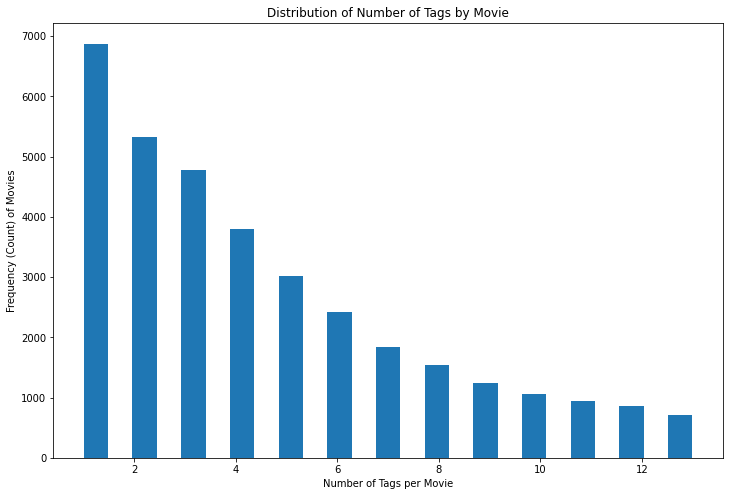

In [125]:
plt.figure(figsize=(12,8))

# Plot histogram
plt.hist(visual_input, bins=25) 

# Titles and Axes
plt.title('Distribution of Number of Tags by Movie')
plt.xlabel('Number of Tags per Movie')
plt.ylabel('Frequency (Count) of Movies')

plt.show()

##### Summary / Findings:
- `count of tags` column was added to `df_tags_of_movies`.
    - The minimum tags per movie is 1, which could be insufficient. I will need to consider setting a minimum tags per movie threshold to reduce the risk that there could be insufficient tags to depict / typify some movies.
    - The median number of tags per movie is 5, which means ~ 50% of the ~45K movies have 5 or less ratings
- For the visualization, I excluded the top 25% of movies with the highest number of tags. 
    - I did this to keep the visualization compact as the top 25% of movies were sparse when it came to number of tags (ranging from 13 to ~6K tags).
- Overall, this distribution is right skewed (i.e. tail on the right side), which was consistent with the statistical metrics we saw above.

### Filter out movies with insufficient tags

The computation power needed for cosine similarity (for *content-based* recommender system) is less than Funk SVD (for *collaborative-based* recommender system), I will aim to set a threshold of tags that will keep the most amount of data while reducing the risk of insufficient data (to depict / typify some movies). </br>
</br>
I will keep movies with at least 5 user tags, as this will allow me to keep more than half of the data while reducing the risks discussed above.  

In [126]:
# Keep only those with a certain threshold of user tags

# Number of minimum user tags
count_tags_threshold = 5

# Update DataFrame
df_tags_of_movies = df_tags_of_movies[df_tags_of_movies['count of tags'] >= count_tags_threshold].copy()

# Print New number of unique movies in DataFrame
print(f"After keeping movies with at least {count_tags_threshold} user tags, there are {df_tags_of_movies.shape[0]:,} unique movies left in the DataFrame.")

After keeping movies with at least 5 user tags, there are 24,478 unique movies left in the DataFrame.


### Add title and genre info to `df_tags_of_movies`

Adding title and genre information from `df_movies` to this `df_tags_of_movies`. This step was intentionally performed after the above filtering to reduce the computation needed.

In [127]:
# Add title and genre to df_tags_of_movies
df_tags_of_movies = pd.merge(left=df_tags_of_movies,               # left table
                             right=df_movies,                      # right table
                             how='left',                           # left join (i.e. return all records on left table)
                             left_on='movieId',                    # column to join on left table
                             right_on='movieId')                   # column to join on right table

##### Summary / Findings:
- `df_tags_of_movies` now ready for export, I will export this dataframe below to use in the 02_Models notebook.

# Section 4 - Export to CSV / NPZ

In this section, I will export the files for the other notebooks in my submission.

I have changed the below code to markdown format. I made this change so that I would not constantly re-write these files when rerunning this notebook.

*Files used in **02_Models** notebook*

**From Section 1:**

```python
# Export - Funk SVD Training Data
df_train_ratings.to_csv('DT_files/DT_df_rating_train.csv')

# Export - Funk SVD Test Data
df_test_ratings.to_csv('DT_files/DT_df_rating_test.csv')

# Export - Funk SVD Full Data (`df_ratings`)
df_ratings.to_csv('DT_files/DT_df_ratings.csv')

```

**From Section 3:**

```python
# Export - Tags of Movies DataFrame
df_tags_of_movies.to_csv('DT_files/DT_df_tags_of_movies.csv')

```

*Files used in **03_Recommendations** notebook*

**From Section 2:**

```python
# Export - Top 50 popular movies 
df_top_50_popular_movies.to_csv('DT_files/DT_df_top_50_popular_movies.csv')

```